In [1]:
!pip install yfinance
!pip install ta
!pip install --upgrade pandas-datareader
!pip install tqdm

Requirement already up-to-date: pandas-datareader in c:\users\weilin\anaconda3\lib\site-packages (0.10.0)


In [2]:
from datetime import date, timedelta
from tqdm import tqdm_notebook
from enum import Enum
from ta.trend import SMAIndicator
from ta.volatility import AverageTrueRange
from statsmodels.tsa.stattools import coint

import numpy as np
import pandas as pd
import math
import heapq as heap
import pandas_datareader as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sb

C:\Users\Weilin\Anaconda3\lib\site-packages\scipy\__init__.py:149: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.16.2
  UserWarning)


In [14]:
# Enum class for different iterations of indicators
class Strategy_Type(Enum):
    RAW_RATIO = "RAW_RATIO"
    MA_RATIO = "MA_RATIO"
    ATR_RATIO = "ATR_RATIO"

In [15]:
# DJ Information technology stocks
stocks = ["AAPL", "MSFT", "V", "CRM", "IBM", "CSCO", "INTC"]
strategy_types = [Strategy_Type.RAW_RATIO, Strategy_Type.MA_RATIO, Strategy_Type.ATR_RATIO]
# strategy_types = [Strategy_Type.ATR_RATIO]

# Trade Class

Trade class encapsulate the logic of handling a single trade in our backtester.
For every Buy - Sell it will be counted as 1 trade. 

A Backtester will have many trades.


In [16]:
class Trade() :
    
    #average open price is the price per stock inlcuding transaction fees
    def __init__(self, symbol, date, open_price, position, quantity, transaction_cost) :
        
        self.symbol = symbol
        self.date = date
        self.open_price = open_price
        self.position = position
        self.quantity = quantity
        self.transaction_cost = transaction_cost
        
        self.total_transaction_cost = self.open_price * self.quantity * transaction_cost
        self.close_price = None
        self.close_date = None
        self.returns = None
        self.raw_profits = None      
        
    def close_trade(self, close_date, close_price) :
        
        self.close_price = close_price
        self.close_date = close_date
        self.total_transaction_cost += self.quantity * close_price * self.transaction_cost
        opening_cost = self.open_price * self.quantity* (1 + self.transaction_cost)
        closing_cost = close_price * self.quantity* (1 + self.transaction_cost)
        
        if self.position == 1 :
            self.returns = np.log(closing_cost / opening_cost)
            self.raw_profits = ((self.close_price - self.open_price) * self.quantity) - self.total_transaction_cost
            
        elif self.position == -1 :
            self.returns = np.log(opening_cost / closing_cost)
            self.raw_profits = ((self.open_price - self.close_price) * self.quantity) - self.total_transaction_cost        
        
        
    def get_unrealised_profits(self, current_price) :
        return (current_price - self.open_price) * self.quantity * self.position
    
    def print_trade(self) :
        action = "Buy" if self.position == 1 else "Sell"
        print("=============================================================")
        print(f"Open Trade {self.symbol} | {self.date[:10]} | {action}")
        print("===============")
        print(f"Open Price: ${round(self.open_price, 2)}")
        print(f"Quantity: {self.quantity}")
        print(f"Transaction Cost: ${round(self.transaction_cost * self.open_price * self.quantity, 2)}")
        print(f"Total Price: ${round(self.open_price * self.quantity* (1 + self.transaction_cost), 2)}")
        print()
        action = "Sell" if self.position == 1 else "Buy"
        print(f"Closing Trade {self.symbol} | {self.close_date[:10]} | {action}")
        print("===============")
        print(f"Close Price: ${round(self.close_price, 2)}" )
        print(f"Quantity: {self.quantity} ")
        print(f"Transaction Cost: ${round(self.transaction_cost * self.close_price * self.quantity, 2)}")
        print(f"Total Transaction Cost: ${round(self.total_transaction_cost, 2)}")
        print(f"Total Price: ${round(self.close_price * self.quantity* (1 + self.transaction_cost), 2)}")
        print(f"Log Returns: {round(self.returns, 2)}")
        print(f"Raw Profits: ${round(self.raw_profits, 2)}")
        print("=============================================================")
        



# BackTester

Since we will be handling multiple stocks, trade logic will be encapsulate in the Trade Class and Backtester class will be mainly handling the logic of Buying and Selling.

We will also need to store the different trades in a dictionary to keep track of all the different stocks. 

# Assumptions Made
1. At a single instance, each individual stock can only have one open trade.

2. Opening and Closing a Trade is counted as 1 Trade together

3. Capital Allocation to each stock is *Total Capital / n stocks* hence all stocks will have equal weights in the strategy.

4. Quantity is calculated base on the price and the transaction cost. <br>
For example, Capital of \\$1000 could buy 9 x \\$10 worth of stocks as the transaction cost is *tc x 9 x 10*. <br>
Hence the price needed is (9 x $10) + (tx x 9 x 10)

5. The formula used to derive the maximum quantity is : *Capital / (price + (price * TC))*

In [27]:
class BackTester():  

    def __init__(self, symbols, start, end, interval, capital, transcation_cost, market_benchmark, verbose = True):

        self.symbols = symbols
        self.start = start
        self.end = end
        self.interval = interval
        self.initial_capital = capital # this is the initial capital you want to trade with
        self.capital = capital # this capital will change depending on trades
        self.stocks_capital = {} ## fix allocation of cash for weach symbol
        self.transaction_cost = transcation_cost # the transaction cost for trading
        self.history_trades = {} #upon closing a trade, the trade will be added here
        self.open_trades = {} # each stock will only have 1 trade open at a time 
        self.verbose = verbose # if you want to see detailed output (logs) 
        self.rolling_capital = pd.DataFrame() # captial daily status
        
        self.market_benchmark = market_benchmark
        
        self.prepare_data() # prepares the data

    def prepare_data(self):
        bt_data = pd.DataFrame()
        for symbol in self.symbols : 
            stock_data = yf.Ticker(symbol)
            hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)
            bt_data[f"Close_Price_{symbol}"] = hist_stock["Close"]
            bt_data[f"High_{symbol}"] = hist_stock["High"]
            bt_data[f"Low_{symbol}"] = hist_stock["Low"]
            bt_data[f"Return_{symbol}"] = np.log(bt_data[f"Close_Price_{symbol}"] / bt_data[f"Close_Price_{symbol}"].shift(1))

        benchmark_stock = yf.Ticker(self.market_benchmark)
        benchmark_hist = benchmark_stock.history(start = self.start, end = self.end, interval = self.interval)
        bt_data[f"Close_Price_{self.market_benchmark}"] = hist_stock["Close"]
        bt_data[f"Return_{self.market_benchmark}"] = np.log(bt_data[f"Close_Price_{self.market_benchmark}"] / bt_data[f"Close_Price_{self.market_benchmark}"].shift(1))
            
        bt_data = bt_data.dropna()
        self.data = bt_data
        
        self.rolling_capital["Date"] = self.data.index
        self.rolling_capital["Capital"] = self.capital
        self.rolling_capital.set_index('Date', inplace=True)
        
    def prepare_cash_allocation(self, tickers) :
        self.stocks_capital = {}
        num_stocks = len(tickers)
        for ticker in tickers :
            self.stocks_capital[ticker] = self.initial_capital / num_stocks
    
    ## resets backtester to initial state
    def reset(self) :
        self.capital = self.initial_capital
        self.history_trades = {}
        self.open_trades = {}
        self.rolling_capital = pd.DataFrame()
        
        self.rolling_capital["Date"] = self.data.index
        self.rolling_capital["Capital"] = self.capital
        self.rolling_capital.set_index('Date', inplace=True)
        
        print("============================")
        print("Resetting BackTester")
        print("============================")
        print()

    def close_graph(self):
        for symbol in self.symbols : 
            plt.figure(figsize=(15, 5))
            plt.plot(self.data[f"Close_Price_{symbol}"] ,color='black', label='Price', linestyle='dashed')
            plt.xlabel("Days")
            plt.ylabel("Price")
            plt.title("Close Prices of {}".format(symbol))
            plt.legend()
            plt.grid()
            plt.show()     

    def return_date_price(self, bar, symbol=None):
        # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
        # Since we have modeled close prices, we will get the price and date
        date = str(self.data.index[bar])
        price = None
        if symbol :
            price = self.data[f"Close_Price_{symbol}"].iloc[bar]
        return date, price

    def realised_balance(self, bar):
        #Returns you the realised capital in your account at a given time period / bar
        date, price = self.return_date_price(bar)
        
        return self.capital

    def unrealised_balance(self, bar):
        #Returns you the unrealised capital (trades in progress) in your account at a given time period / bar
        ub = 0
        for symbol, trade in self.open_trades.items() :
            date, price = self.return_date_price(bar, symbol)
            if trade.position == 1 :
                ub += trade.quantity * price
            else :
                opening_cost = trade.open_price * trade.quantity
                price_delta = price - trade.open_price
                profits = price_delta * trade.quantity
                ub += profits + opening_cost
                
        return ub
            

    def total_balance(self, bar):
        #Unrealised plus realised
        ub = self.unrealised_balance(bar)
        tb = ub + self.capital
        
        return tb

    def get_returns(self) :
        return round(((self.capital - self.initial_capital) / self.initial_capital)  * 100, 2)
    
    def get_annual_gross_returns(self) :
        daily_log_mean_returns = self.rolling_capital["Capital_Log_Returns"].mean()
        annual_log_returns = 252 * daily_log_mean_returns
        annual_reg_returns = (np.exp(annual_log_returns) - 1) * 100
        
        return round(annual_reg_returns, 2)
    
    def get_market_returns(self) :
        market_log_returns = self.data[f"Return_{self.market_benchmark}"].sum()
        market_returns = (np.exp(market_log_returns) - 1) * 100      
        
        return round(market_returns, 2)
     
    def get_market_annual_gross_returns(self) :
        market_daily_log_mean_returns = self.data[f"Return_{self.market_benchmark}"].mean()
        market_annual_log_returns = 252 * market_daily_log_mean_returns
        market_annual_reg_returns = (np.exp(market_annual_log_returns) - 1) * 100
        
        return round(market_annual_reg_returns, 2)

    def buy_order(self, bar, symbol, quantity=None, dollar=None,):
        date, price = self.return_date_price(bar, symbol)
        quant = 0
        
        # if symbol is in open trades, there is a open short position
        if symbol in self.open_trades :
            current_trade = self.open_trades[symbol]
            current_trade.close_trade(close_date=date, close_price=price)
            
            if symbol in self.history_trades : 
                self.history_trades[symbol].append(current_trade)
            else : 
                self.history_trades[symbol] = [current_trade]
            
            quant = current_trade.quantity
            price_delta = current_trade.open_price - price
            
            difference = price_delta * quant 
            
            open_sum = current_trade.open_price * current_trade.quantity
            
            self.capital = self.capital - (quant * price)*(self.transaction_cost) + open_sum + difference
            self.stocks_capital[symbol] = open_sum + difference - (quant * price)*(self.transaction_cost)
            
            del self.open_trades[symbol]
        else :
            if quantity == None:
                quant = math.floor(self.stocks_capital[symbol] / (price + (self.transaction_cost * price)))
                
            new_trade = Trade(symbol=symbol, date=date, open_price=price, position=1, quantity=quant, transaction_cost=self.transaction_cost)
            self.open_trades[symbol] = new_trade 
            
            self.capital = self.capital - ((quant * price)*(1 + self.transaction_cost)) # capital will be lost in buying
            self.stocks_capital[symbol] = self.stocks_capital[symbol] - (quant * price)*(1 + self.transaction_cost)
                       
            
    def sell_order(self, bar, symbol, quantity=None, dollar=None):
        date, price = self.return_date_price(bar, symbol)
        quant = 0
        
        # if symbol is in open trades, there is a open long position
        if symbol in self.open_trades :
            current_trade = self.open_trades[symbol]
            current_trade.close_trade(close_date=date, close_price=price)
            if symbol in self.history_trades : 
                self.history_trades[symbol].append(current_trade)
            else : 
                self.history_trades[symbol] = [current_trade]
            
            quant = current_trade.quantity
            self.capital = self.capital + ((quant * price)*(1 - self.transaction_cost)) # capital will be added after selling
            self.stocks_capital[symbol] = (quant * price)*(1 - self.transaction_cost)
            
            del self.open_trades[symbol]
            
        else :
            if quantity == None:
                quant = math.floor(self.stocks_capital[symbol] / (price + (self.transaction_cost * price)))
            new_trade = Trade(symbol=symbol, date=date, open_price=price, position=-1, quantity=quant, transaction_cost=self.transaction_cost)
            self.open_trades[symbol] = new_trade
            
            self.capital = self.capital - ((quant * price)*(1 + self.transaction_cost))
            self.stocks_capital[symbol] = self.stocks_capital[symbol]- (quant * price)*(1 + self.transaction_cost)

    # Close any open position at the end of the backtesting
    def last_trade(self, bar):
        for symbol, trade in  self.open_trades.items() : 
            
            date, price = self.return_date_price(bar, symbol)
            
            trade.close_trade(close_date=date, close_price=price)
            
            if trade.position == 1 :
                self.history_trades[symbol].append(trade)
                quant = trade.quantity
                self.capital = self.capital + ((quant * price)*(1 - self.transaction_cost)) # capital will be added after selling
                self.stocks_capital[symbol] = (quant * price)*(1 - self.transaction_cost)
                
            else :
                self.history_trades[symbol].append(trade)
                quant = trade.quantity
                price_delta = trade.open_price - price

                difference = price_delta * quant 

                open_sum = trade.open_price * trade.quantity

                self.capital = self.capital - (quant * price)*(self.transaction_cost) + open_sum + difference
                self.stocks_capital[symbol] = open_sum + difference - (quant * price)*(self.transaction_cost)
        
        self.rolling_capital["Capital"].iloc[bar] = self.capital
        print(self.capital)

        
    def calcuate_total_trades(self) :
        total_trades = 0
        for symbol, trades in self.history_trades.items() :
            total_trades += len(trades)

        return total_trades
    
    def log_all_trades(self) :
        for ticker, trades in self.history_trades.items() :
            for trade in trades : 
                trade.print_trade()
                
    def get_annual_reg_std(self) :
        daily_regular_std = (np.exp(self.rolling_capital["Capital_Log_Returns"]) - 1).std()
        annual_regular_std = daily_regular_std * (252**0.5) * 100
        
        return round(annual_regular_std, 2)
    
    def get_market_annual_reg_std(self) :
        daily_regular_std = (np.exp(self.data[f"Return_{self.market_benchmark}"]) - 1).std()
        annual_regular_std = daily_regular_std * (252**0.5) * 100
        
        return round(annual_regular_std, 2)
    
                                
    def get_beta(self) :
        cov = self.data[f"Return_{self.market_benchmark}"].cov(self.rolling_capital["Capital_Log_Returns"])
        market_var = self.data[f"Return_{self.market_benchmark}"].var()
                
        beta = cov/market_var
        
        return round(beta, 2)
    
    def get_alpha(self) :
        strategy_returns = self.get_annual_gross_returns()
        market_returns = self.get_market_annual_gross_returns()
        beta = self.get_beta()
        alpha = (strategy_returns - (beta * (market_returns)))
        
        return round(alpha, 2)
    
    
    def get_sharpe_ratio(self) :
        annual_regular_returns = self.get_annual_gross_returns()
        annual_regular_std = self.get_annual_reg_std()
        
        sharpe_ratio = annual_regular_returns / annual_regular_std
        
        return round(sharpe_ratio, 2)
    
    def plot_strategy_returns_market_returns(self) :
        plt.figure(figsize=[15,5])
        plt.plot(self.rolling_capital["Capital_Log_Returns"].cumsum(), label="Strategy Returns")
        plt.plot(self.data[f"Return_{self.market_benchmark}"].cumsum(), label=f"{self.market_benchmark} Returns")
        plt.title("Strategy Log Returns VS DJI Log Returns")
        
        plt.legend()
        plt.show()
        plt.close()       
        
        
    def performance(self) :
        self.rolling_capital["Capital_After_Resettlement"] = self.rolling_capital["Capital"].shift(-1)

        self.rolling_capital['Capital_Regular_Returns'] = (self.rolling_capital['Capital_After_Resettlement']/self.rolling_capital['Capital'] - 1)
        self.rolling_capital['Capital_Log_Returns'] = np.log(self.rolling_capital['Capital_After_Resettlement'] / self.rolling_capital['Capital'])
        self.rolling_capital['Capital_Returns_Log_Cum_Sum'] = self.rolling_capital['Capital_Log_Returns'].cumsum()

        self.rolling_capital['Cum_Max'] = self.rolling_capital['Capital_Returns_Log_Cum_Sum'].cummax()

        self.rolling_capital[["Capital_Returns_Log_Cum_Sum", f"Cum_Max"]].dropna().plot(figsize =(15,6), title="Capital DrawDown")
        
        strategy_returns = self.get_returns()
        annual_gross_returns = self.get_annual_gross_returns()
        strategy_std = self.get_annual_reg_std()
        alpha = self.get_alpha()
        beta = self.get_beta()
        sharpe_ratio = self.get_sharpe_ratio()
        
        market_returns = self.get_market_returns()
        market_annual_returns = self.get_market_annual_gross_returns()
        market_std = self.get_market_annual_reg_std()
        
        
        print()
        print("Strategy Performance")
        print("==================================")
        print(f"Strategy Returns: {strategy_returns}%")
        print(f"Strategy Annual Gross Returns: {annual_gross_returns}%")
        print(f"Strategy Standard Deviation: {strategy_std}")
        print(f"Alpha: {alpha}")
        print(f"Beta: {beta}")
        print(f"Sharpe Ratio: {sharpe_ratio}")
        print()
        print("Market Performance")
        print("==================================")
        print(f"Market Returns: {market_returns}%")
        print(f"Market Annual Gross Returns: {market_annual_returns}%")
        print(f"Market Standard Deviation: {market_std}")
        
        self.plot_strategy_returns_market_returns()

    def calmar_ratio(self) :
        max_drawdown = max(self.rolling_capital['Cum_Max'] - self.rolling_capital['Capital_Returns_Log_Cum_Sum'])
        return self.get_returns()/(max_drawdown*100)

    def sortino_ratio(self) :
        negative_returns_df = self.rolling_capital[self.rolling_capital["Capital_Log_Returns"] < 0]
        negative_returns = negative_returns_df["Capital_Log_Returns"]

        negative_regular_returns = np.exp(negative_returns) - 1

        annual_negative_sd = negative_regular_returns.std() * (252 ** 0.5)

        sortino = (self.get_returns() / 100) / annual_negative_sd

        return round(sortino, 2)

    def information_ratio(self) :   

        temp_data = self.rolling_capital.copy()

        temp_data["Market_Returns"] = self.data[f"Return_{self.market_benchmark}"]

        temp_data["Strategy_Benchmark"] = temp_data["Capital_Log_Returns"] - temp_data["Market_Returns"]

        average_of_difference = temp_data["Strategy_Benchmark"].mean()

        std_dev_of_difference = temp_data["Strategy_Benchmark"].std()

        IR_daily = average_of_difference / std_dev_of_difference
        IR_annual = IR_daily * (252 ** 0.5)

        return round(IR_annual, 2)

    def treynor_ratio(self) :
        
        strategy_returns = self.get_returns() / 100
        beta = self.get_beta()
        treynor_ratio = strategy_returns / beta
        
        return round(treynor_ratio, 2)

    def get_extended_metrics(self) :
        print(f"Calmar Ratio: {self.calmar_ratio()}")
        print(f"Sortino Ratio: {self.sortino_ratio()}")
        print(f"Annual Information Ratio: {self.information_ratio()}")
        print(f"Treynor Ratio: {self.treynor_ratio()}")
 

SyntaxError: invalid syntax (<ipython-input-27-46d05d68b2d7>, line 315)

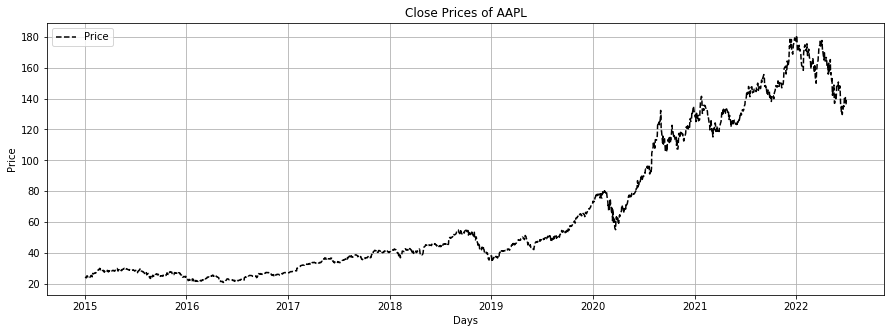

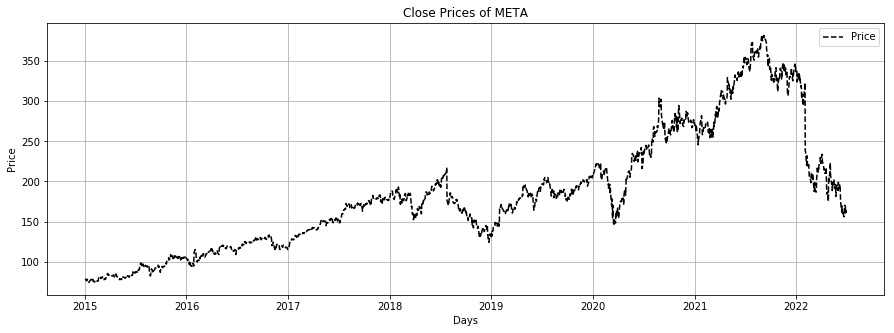

In [18]:
#check if common class runs fine
A = BackTester(["AAPL", "META"], "2015-01-01", "2022-07-01","1d", 10000, 0.0, "^GSPC", False)
A.close_graph()

In [23]:
class Pair_Strategy(BackTester):
    
    def __init__(self, symbols, start, end, interval, capital, 
                 transcation_cost, market_benchmark, verbose = True, 
                 cointegration_threshold = 0.05, number_pairs = 3, 
                 types = [Strategy_Type.RAW_RATIO, Strategy_Type.MA_RATIO, Strategy_Type.ATR_RATIO]) :
        
        super().__init__(symbols, start, end, interval, capital, transcation_cost, market_benchmark, verbose)
        
        self.types = types
        
        self.cointegration_matrix =  np.zeros((len(symbols), len(symbols))) # cointegration p value for all permutations 
        self.selected_pairs = [] # list of selected pairs the strategy will run
        self.cointegration_heap = [] # min heap for sorting ans selecting of pairs
        self.cointegration_threshold = cointegration_threshold
        self.number_pairs = number_pairs
        
        self.price_signals = pd.DataFrame()
        
        # thresholds for different indicators for generating signals
        self.strategy_threshold = {Strategy_Type.RAW_RATIO : 1, 
                                  Strategy_Type.MA_RATIO : 0.75,
                                  Strategy_Type.ATR_RATIO : 1}
        
    
    def __get_cointegration_p_value__(self, ticker_1, ticker_2) :
        
        results = coint(self.data[f"Close_Price_{ticker_1}"], self.data[f"Close_Price_{ticker_2}"])
        return results[1]
    
    def __compute_pairs__(self) :
        
        for i in range(len(self.symbols)) :
            for j in range(i + 1, len(self.symbols)) :
                coint_p_value = self.__get_cointegration_p_value__(self.symbols[i], self.symbols[j])
                self.cointegration_matrix[i, j] = coint_p_value
                
                # we wil be using min heap to keep track of the lowest p-value
                heap.heappush(self.cointegration_heap, (coint_p_value, f"{self.symbols[i]}/{self.symbols[j]}"))
                
        if self.verbose :  
            ## Cointegration Matrix
            plt.figure(figsize = (16,6))
            sb.heatmap(self.cointegration_matrix, xticklabels=self.symbols, yticklabels=self.symbols, annot=True, mask=(self.cointegration_matrix == 0))
            plt.title("Conintegrations p-value Matrix")
            plt.show()
                               
    def __select_pairs__(self) :
    
        selected_map = {}

        min_cointegration = self.cointegration_matrix.min()
        
        if (min_cointegration >= self.cointegration_threshold) :
            print("No Suitables Pairs Found based on Cointegration Test")
            print(f"Selecting the next best {self.number_pairs} unique pairs")
            
        while len(self.selected_pairs) < self.number_pairs :
            try : 
                pair = heap.heappop(self.cointegration_heap)[1]
                ticker_1, ticker_2 = self.__get_tickers_from_pair(pair)

                if ticker_1 not in selected_map and ticker_2 not in selected_map :
                    self.selected_pairs.append(pair)

                    selected_map[ticker_1] = 1
                    selected_map[ticker_2] = 1 
            except IndexError :
                print(f"Unable to find {self.number_pairs} Unique Pairs")
                print(f"Only {len(self.selected_pairs)} Unique Pairs Found")
                print()
                break;
                
        if self.verbose :
            print(f"Selected Pairs: {self.selected_pairs}")
    
    ## compute price ratio of a single pair
    def compute_price_ratio(self, pair) :
        
        ticker_1, ticker_2 = self.__get_tickers_from_pair(pair)
        
        price_ratio = self.data[f"Close_Price_{ticker_1}"]/ self.data[f"Close_Price_{ticker_2}"]
        
        if self.verbose :
            price_ratio.plot(figsize=(16,5))
            plt.title(f"{pair} Price Ratio")
            plt.axhline(price_ratio.mean())
            plt.legend(['Mean'])
            plt.show()
            plt.close()
        
        return price_ratio
    
    
    # compute 2(Long term and short term) moving MAs of the spread of a given pair
    def compute_rolling_price_ratio(self, price_ratio, STMA_window = 10, LTMA_window = 50) :
        
        indicator_1 = SMAIndicator(close=price_ratio, window=STMA_window, fillna=False)
        STMA = indicator_1.sma_indicator()
            
        indicator_2 = SMAIndicator(close=price_ratio, window=LTMA_window, fillna=False)
        LTMA= indicator_2.sma_indicator()
        
        if self.verbose :
            vis_df = pd.DataFrame()
            vis_df["Price_Ratio"] = price_ratio
            vis_df["STMA"] = STMA
            vis_df["LTMA"] = LTMA
            
            plt.figure(figsize=[15,5])
            plt.title(f"MA Price Ratio, {price_ratio.name}")
            plt.plot(vis_df["Price_Ratio"], label="Price Ratio")
            plt.plot(vis_df["STMA"], label="STMA")
            plt.plot(vis_df["LTMA"], label="LTMA")
            
            plt.legend()
            plt.show()
            plt.close()         
        
        return STMA, LTMA
    
    
    #compute ATR price ratios of a given pair
    def compute_atr_price_ratios(self, pair, window= 14) :
        pair_tuple = pair.split("/")
        ticker_1 = pair_tuple[0]
        ticker_2 = pair_tuple[1]
        
        ATR_1 = AverageTrueRange(high=self.data[f"High_{ticker_1}"], low=self.data[f"Low_{ticker_1}"], close=self.data[f"Close_Price_{ticker_1}"], window=window)
        ATR_2 = AverageTrueRange(high=self.data[f"High_{ticker_2}"], low=self.data[f"Low_{ticker_2}"], close=self.data[f"Close_Price_{ticker_2}"], window=window)
        
        ATR_1_values = ATR_1.average_true_range()
        ATR_2_values = ATR_2.average_true_range()
        
        ATR_ratio = ATR_1_values / ATR_2_values
        
        ATR_spread = (self.data[f"Close_Price_{ticker_1}"] / self.data[f"Close_Price_{ticker_2}"]) * ATR_ratio
        
        ATR_spread.name = f"ATR {pair}"
        
        if self.verbose :
            plt.figure(figsize=[15,5])
            plt.title(f"ATR Price Ratio, {pair}")
            plt.plot(ATR_spread, label="ATR Price Ratio")
            
            plt.legend()
            plt.show()
            plt.close()         
        
        return ATR_spread
        
    
    # compute the z score given a price ratio
    def compute_z_scores(self, price_ratio, strategy_type, STMA = None, LTMA= None) :
        if LTMA is not None and STMA is not None:
            mean = LTMA
            name = f"MA {price_ratio.name}"
            price_ratio = STMA
            price_ratio.name=name
            
        else :
            mean = price_ratio.mean()
            
        z_score = (price_ratio - mean) / np.std(price_ratio)
        
        if self.verbose :
            z_score.plot(figsize=(15,5))
            plt.title(f"Z-score Plot, {price_ratio.name}")
            plt.axhline(z_score.mean(), color='black')
            plt.axhline(self.strategy_threshold[strategy_type], color='red', linestyle='--')
            plt.axhline(-self.strategy_threshold[strategy_type], color='green', linestyle='--')
            plt.legend(['Z-score', 'Mean'])
            plt.show()
        
        
        return z_score
    
    def __generate_trading_tickers_from_pairs__(self) :
        trading_tickers = []
        
        for pair in self.selected_pairs :
            ticker_1, ticker_2 = self.__get_tickers_from_pair(pair)
            trading_tickers.append(ticker_1)
            trading_tickers.append(ticker_2)
            
        return trading_tickers
    
    def __get_tickers_from_pair(self, pair) :
        
        pair_split = pair.split("/")
        
        return pair_split[0], pair_split[1]
            
    
    def __prepare_signals__(self) :
        self.__compute_pairs__()
        self.__select_pairs__()
        
        for pair in self.selected_pairs :
            
            price_ratio = self.compute_price_ratio(pair)
            price_ratio.name = pair
            
            rolling_price_ratio_STMA, rolling_price_ratio_LTMA = self.compute_rolling_price_ratio(price_ratio, STMA_window=5, LTMA_window = 60)
            
            atr_ratio = self.compute_atr_price_ratios(pair, window=14)
            
            price_ratio_zscore = self.compute_z_scores(price_ratio, strategy_type=Strategy_Type.RAW_RATIO)
            
            rolling_price_ratio_zscore = self.compute_z_scores(price_ratio, strategy_type=Strategy_Type.MA_RATIO, STMA=rolling_price_ratio_STMA, LTMA=rolling_price_ratio_LTMA)
            
            atr_zscore = self.compute_z_scores(atr_ratio, strategy_type=Strategy_Type.ATR_RATIO)
            
            self.price_signals[f"{pair}_RAW_RATIO_Zscore"] = price_ratio_zscore
            self.price_signals[f"{pair}_MA_RATIO_Zscore"] = rolling_price_ratio_zscore
            self.price_signals[f"{pair}_ATR_RATIO_Zscore"] = atr_zscore
            
    def __plot_positions__(self, ) :

        for pair in self.selected_pairs :
        
            ticker_1, ticker_2 = self.__get_tickers_from_pair(pair)
            
            plt.figure(figsize=[15,5])
            plt.plot(self.data[f"Close_Price_{ticker_1}"], label=ticker_1)
            plt.plot(self.data[f"Close_Price_{ticker_2}"], label=ticker_2)

            long_dates = []
            long_prices = []
            short_dates = []
            short_prices = []
            close_dates = []
            close_prices = []

            for trade in self.history_trades[ticker_1] :

                close_dates.append(trade.close_date)
                close_prices.append(trade.close_price)

                if trade.position == 1 :
                    long_dates.append(trade.date)
                    long_prices.append(trade.open_price)

                else :
                    short_dates.append(trade.date)
                    short_prices.append(trade.open_price)

            for trade in self.history_trades[ticker_2] :

                close_dates.append(trade.close_date)
                close_prices.append(trade.close_price)

                if trade.position == 1 :
                    long_dates.append(trade.date)
                    long_prices.append(trade.open_price)

                else :
                    short_dates.append(trade.date)
                    short_prices.append(trade.open_price)
        
            plt.scatter(long_dates, long_prices, label='Buy', marker='^', c='g', s=200)

            plt.scatter(short_dates, short_prices, label ='Short', marker='v', c='r', s=200)

            plt.scatter(close_dates, close_prices, label='Close', marker='x', c='black', s=100)

            plt.legend()
            plt.show()
            plt.close()
            
        
    def go_long(self, bar, symbol, quantity = None, dollar = None) :
        
        if symbol in self.open_trades:
            self.buy_order(bar, symbol)
            
        elif quantity :
            self.buy_order(bar, symbol, quantity=quantity)
        elif dollar :
            if dollar == "all":
                dollar = self.stocks_capital[symbol] # capital is limited to the size of stock per trade
            self.buy_order(bar, symbol, dollar=dollar)
    
    def go_short(self, bar, symbol, quantity = None, dollar = None):
        if symbol in self.open_trades:
            self.sell_order(bar, symbol)
        if quantity :
            self.sell_order(bar, symbol, quantity = quantity)
        elif dollar :
            if dollar == "all" :
                dollar = self.stocks_capital[symbol] # capital is limited to the size of stock per trade
            self.sell_order(bar, symbol, dollar=dollar)
            
    def close_trade(self, bar, symbol) :
        current_trade = self.open_trades[symbol] 
        
        if current_trade.position == 1 :
            self.go_short(bar, symbol)
        else :
            self.go_long(bar, symbol)

    def run_strategy(self) :
        self.__prepare_signals__()
        self.capital = self.initial_capital
        traded_tickers = self.__generate_trading_tickers_from_pairs__()
        
        for strategy_type in self.types :

            self.prepare_cash_allocation(traded_tickers)
            strategy_type_name = strategy_type.name
            
            print(f"Strategy Iteration: {strategy_type_name}")
            
            
            for bar in tqdm_notebook(range(len(self.price_signals))) :
                
                for pair in self.selected_pairs :
                    
                    ticker_1 , ticker_2 = self.__get_tickers_from_pair(pair)
                    
                    # if there is no open trades on ticker_1 -> go long for the pair
                    if ticker_1 not in self.open_trades :
                        
                        # buy signal -> long ticker_1 , short ticker_2
                        # if zscore is within 0.05 of the buy signal 
                        if self.price_signals[f"{pair}_{strategy_type_name}_Zscore"].iloc[bar]  + self.strategy_threshold[strategy_type] <= 0.05 :
                            self.go_long(bar, ticker_1, dollar="all")
                            self.go_short(bar, ticker_2, dollar="all")
                        
                        # sell signal -> short ticker_1, long -> ticker_2
                        # if zscore is within 0.05 of the buy signal 
                        elif self.strategy_threshold[strategy_type] - self.price_signals[f"{pair}_{strategy_type_name}_Zscore"].iloc[bar]  <= 0.05 :
                            self.go_short(bar, ticker_1, dollar="all")
                            self.go_long(bar, ticker_2, dollar="all")
                    
                    elif (ticker_1 in self.open_trades) and (0.1 >= self.price_signals[f"{pair}_{strategy_type_name}_Zscore"].iloc[bar] >= -0.1) :
                        self.close_trade(bar, ticker_1)
                        self.close_trade(bar, ticker_2)
                    
                    self.rolling_capital["Capital"].iloc[bar] = self.total_balance(bar)
                
            self.last_trade(bar)
                        
            if self.verbose :
                self.log_all_trades()
                self.__plot_positions__()
                
            self.performance()
            self.get_extended_metrics()
            self.reset()
                

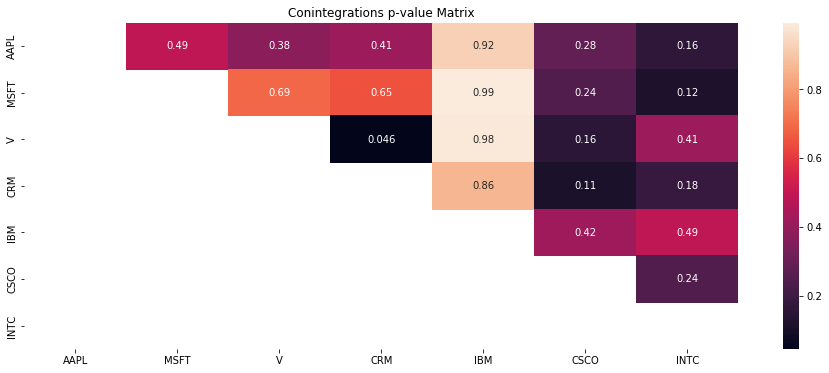

Selected Pairs: ['V/CRM', 'MSFT/INTC', 'AAPL/CSCO']


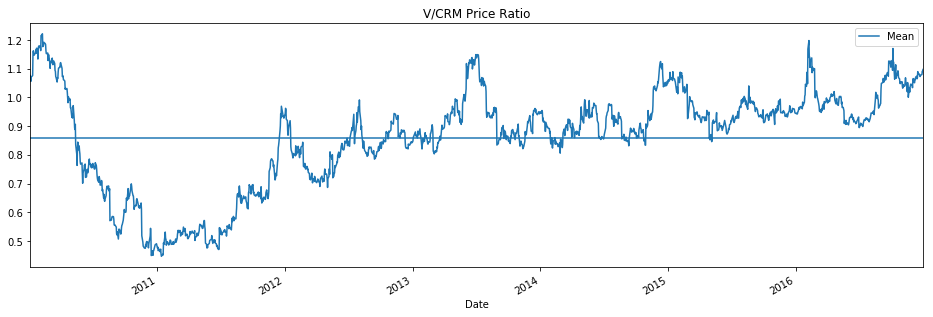

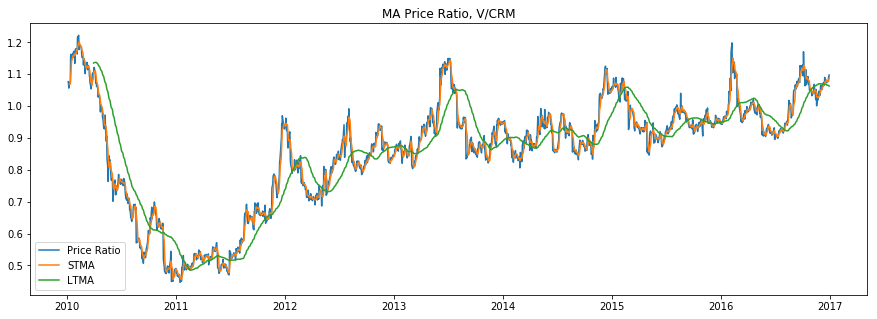

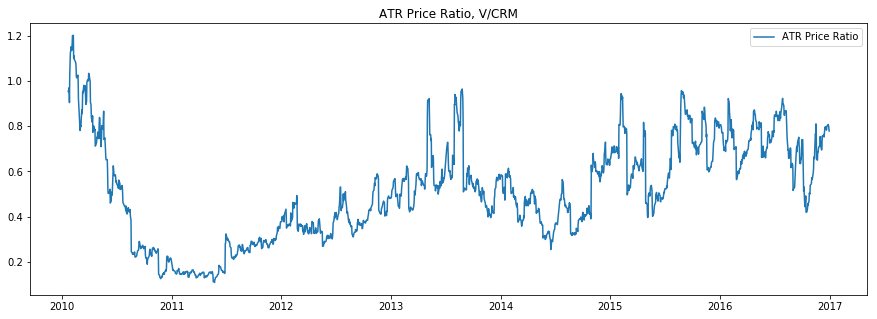

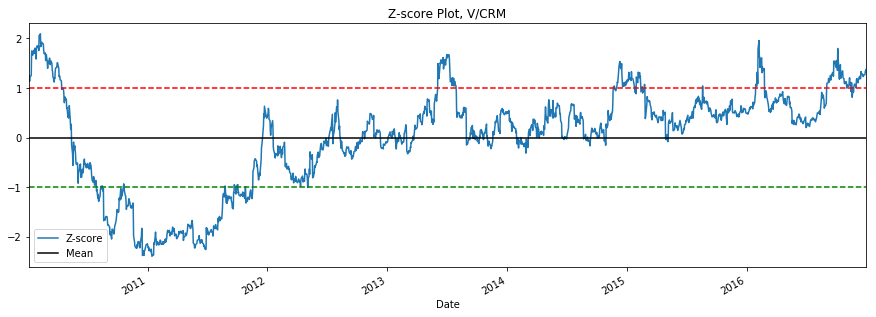

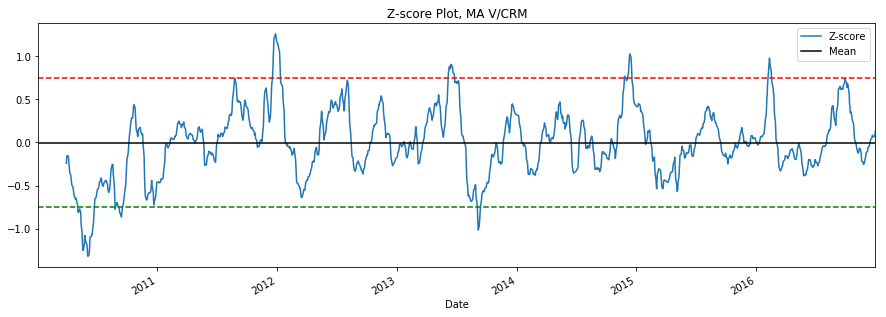

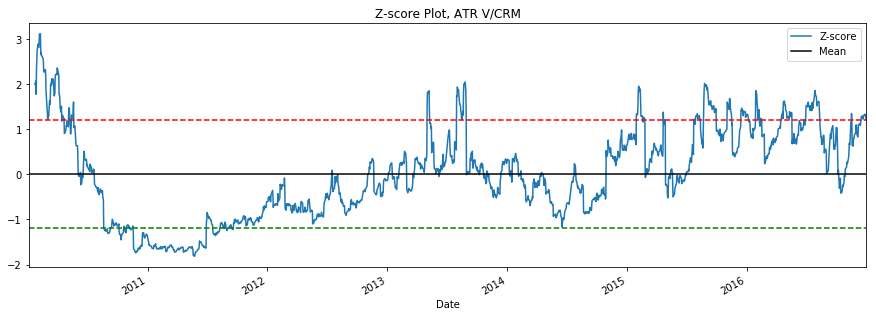

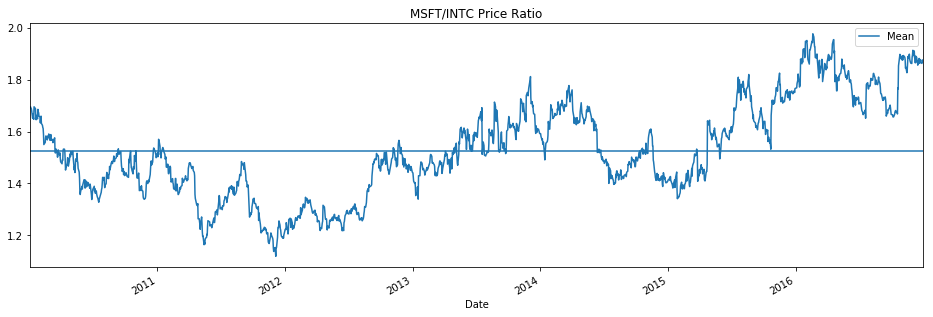

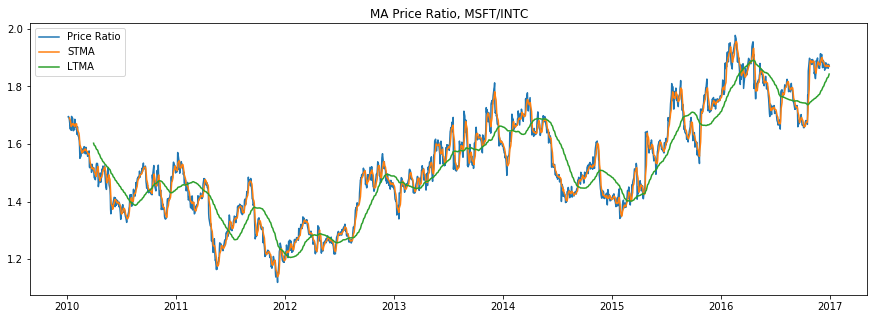

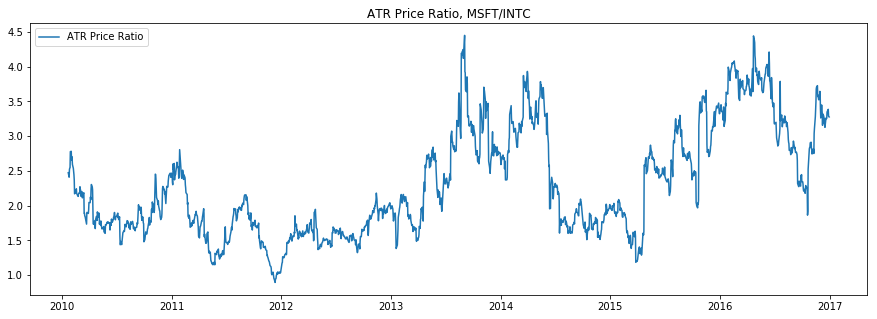

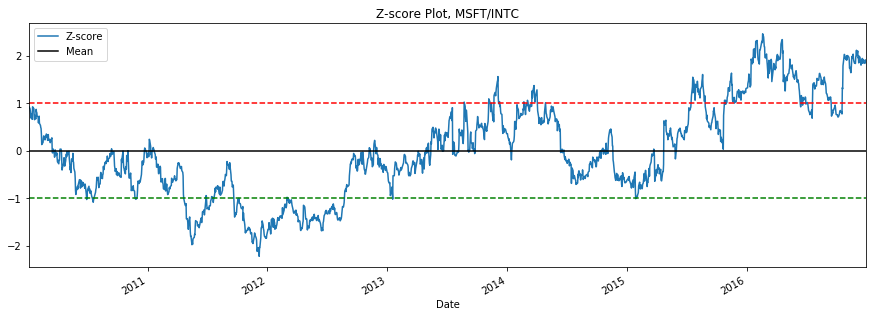

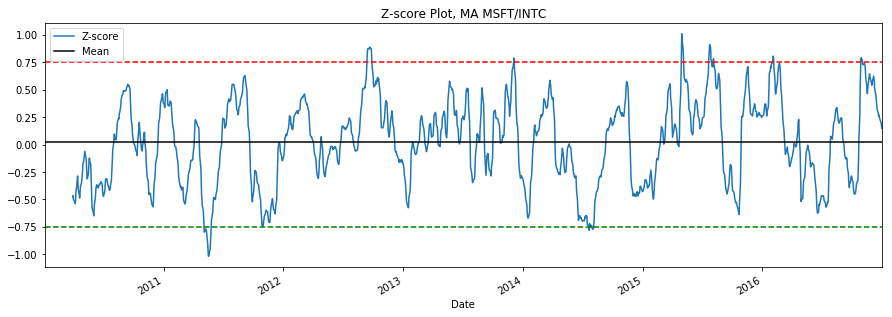

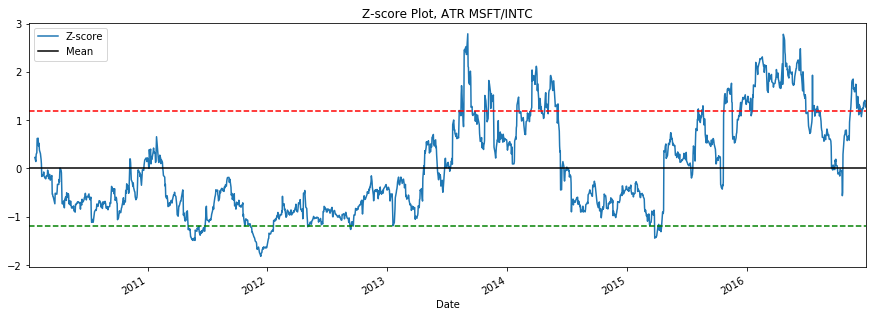

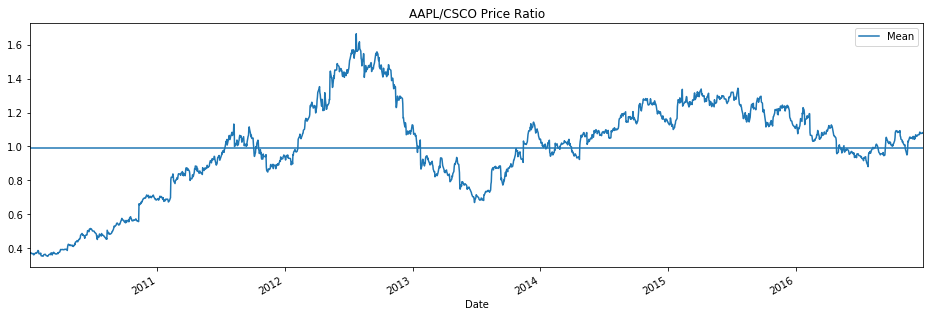

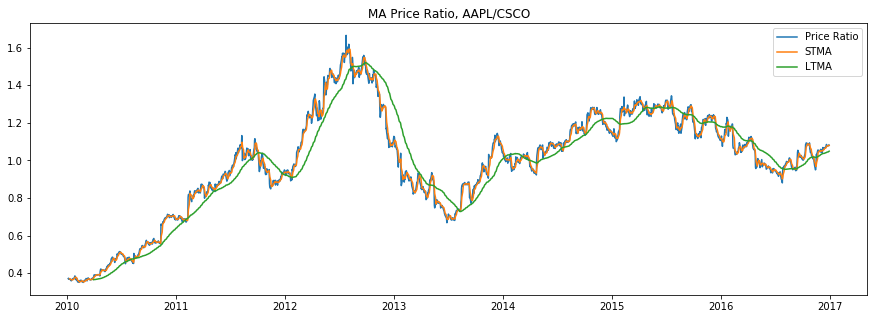

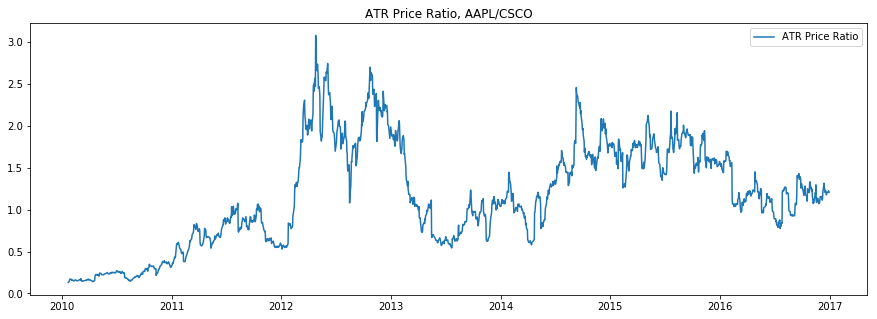

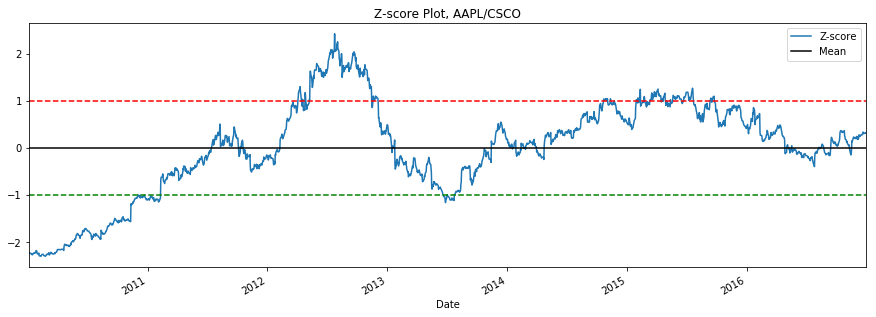

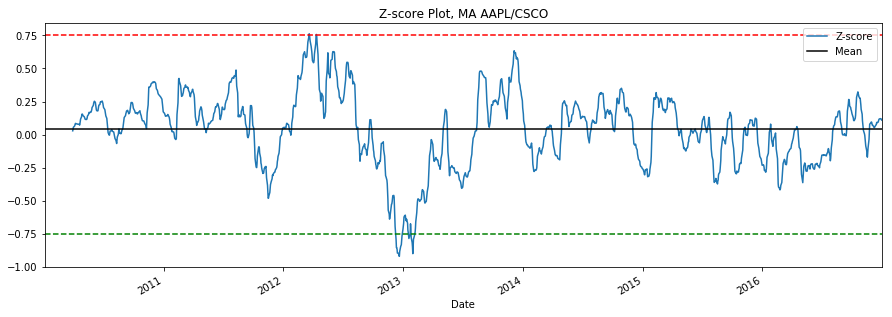

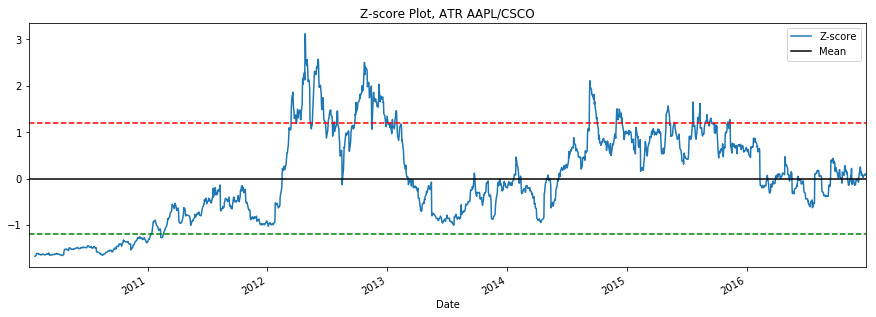

Strategy Iteration: RAW_RATIO



797816.9491092348
Open Trade V | 2010-01-04 | Sell
Open Price: $20.14
Quantity: 4096
Transaction Cost: $824.92
Total Price: $83316.95

Closing Trade V | 2010-05-20 | Buy
Close Price: $16.69
Quantity: 4096 
Transaction Cost: $683.58
Total Transaction Cost: $1508.5
Total Price: $69041.3
Log Returns: 0.19
Raw Profits: $12625.81
Open Trade V | 2010-07-23 | Buy
Open Price: $17.32
Quantity: 5483
Transaction Cost: $949.86
Total Price: $95935.85

Closing Trade V | 2011-12-16 | Sell
Close Price: $22.59
Quantity: 5483 
Transaction Cost: $1238.7
Total Transaction Cost: $2188.56
Total Price: $125109.04
Log Returns: 0.27
Raw Profits: $26695.78
Open Trade V | 2012-04-11 | Buy
Open Price: $27.27
Quantity: 4452
Transaction Cost: $1213.92
Total Price: $122606.17

Closing Trade V | 2012-06-22 | Sell
Close Price: $29.08
Quantity: 4452 
Transaction Cost: $1294.65
Total Transaction Cost: $2508.57
Total Price: $130759.89
Log Returns: 0.06
Raw Profits: $5564.42
Open Trade V | 2013-06-03 | Sell
Open Price: $

Transaction Cost: $1244.77
Total Price: $125721.77

Closing Trade MSFT | 2014-01-13 | Buy
Close Price: $29.8
Quantity: 3856 
Transaction Cost: $1149.09
Total Transaction Cost: $2393.86
Total Price: $116058.13
Log Returns: 0.08
Raw Profits: $7174.1
Open Trade MSFT | 2014-01-31 | Sell
Open Price: $32.24
Quantity: 4081
Transaction Cost: $1315.57
Total Price: $132872.9

Closing Trade MSFT | 2014-06-13 | Buy
Close Price: $35.64
Quantity: 4081 
Transaction Cost: $1454.37
Total Transaction Cost: $2769.94
Total Price: $146891.32
Log Returns: -0.1
Raw Profits: $-16649.57
Open Trade MSFT | 2015-01-28 | Buy
Open Price: $36.05
Quantity: 3191
Transaction Cost: $1150.4
Total Price: $116190.18

Closing Trade MSFT | 2015-03-18 | Sell
Close Price: $37.46
Quantity: 3191 
Transaction Cost: $1195.43
Total Transaction Cost: $2345.83
Total Price: $120738.68
Log Returns: 0.04
Raw Profits: $2157.63
Open Trade MSFT | 2015-07-16 | Sell
Open Price: $41.4
Quantity: 2830
Transaction Cost: $1171.53
Total Price: $11

Quantity: 11519 
Transaction Cost: $1892.88
Total Transaction Cost: $3439.52
Total Price: $191180.46
Log Returns: 0.2
Raw Profits: $31183.63
Open Trade AAPL | 2014-10-22 | Sell
Open Price: $23.08
Quantity: 8040
Transaction Cost: $1855.34
Total Price: $187389.7

Closing Trade AAPL | 2016-05-02 | Buy
Close Price: $21.55
Quantity: 8040 
Transaction Cost: $1732.44
Total Transaction Cost: $3587.78
Total Price: $174976.11
Log Returns: 0.07
Raw Profits: $8702.91
Open Trade CSCO | 2010-01-04 | Sell
Open Price: $17.53
Quantity: 4705
Transaction Cost: $824.93
Total Price: $83318.2

Closing Trade CSCO | 2011-07-08 | Buy
Close Price: $11.26
Quantity: 4705 
Transaction Cost: $529.74
Total Transaction Cost: $1354.68
Total Price: $53504.24
Log Returns: 0.44
Raw Profits: $28164.1
Open Trade CSCO | 2012-03-19 | Buy
Open Price: $14.51
Quantity: 7606
Transaction Cost: $1103.78
Total Price: $111481.31

Closing Trade CSCO | 2013-01-14 | Sell
Close Price: $15.46
Quantity: 7606 
Transaction Cost: $1176.24
To

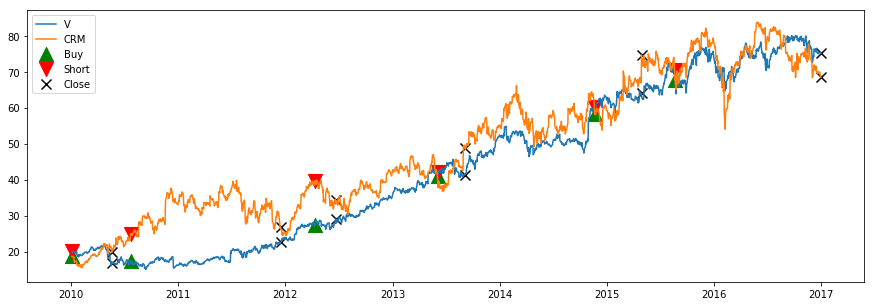

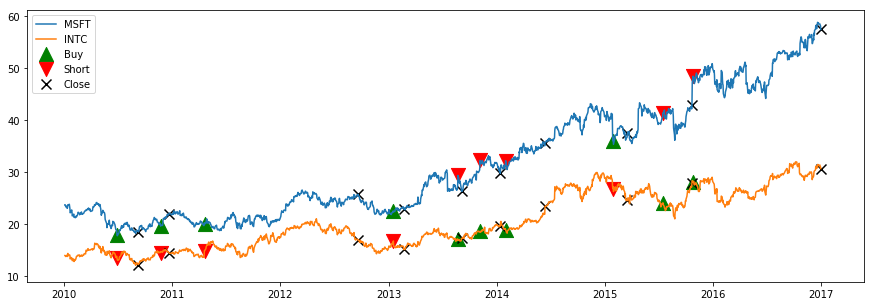

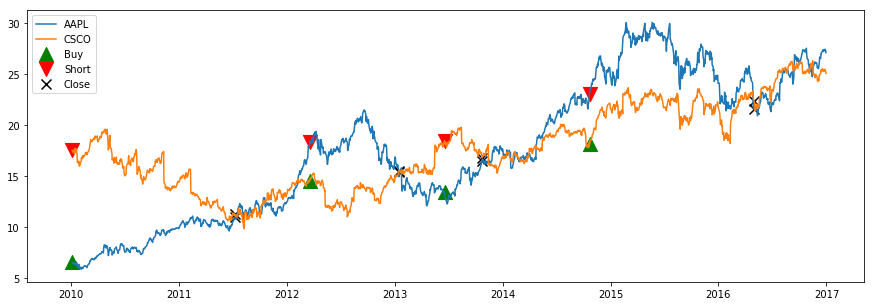


Strategy Performance
Strategy Returns: 59.56%
Strategy Annual Gross Returns: 7.02%
Strategy Standard Deviation: 15.24
Alpha: 7.02
Beta: 0.0
Sharpe Ratio: 0.46

Market Performance
Market Returns: 124.17%
Market Annual Gross Returns: 12.24%
Market Standard Deviation: 23.46


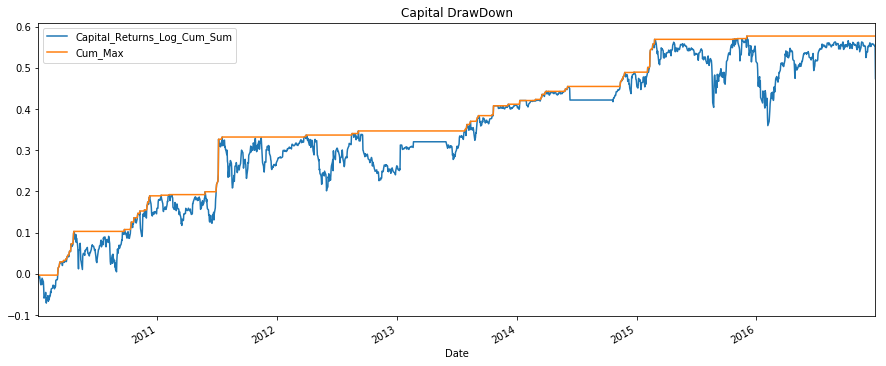

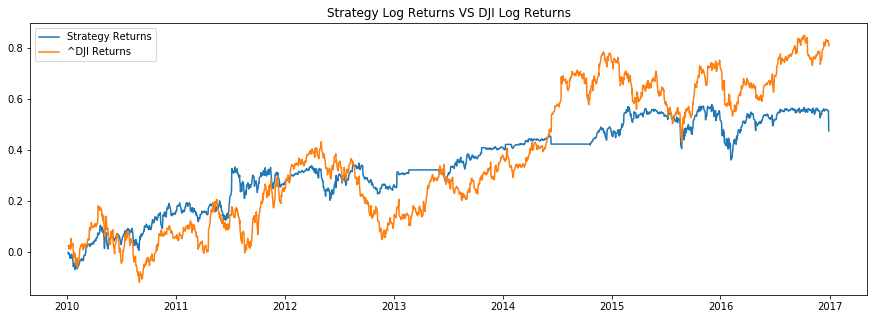

Resetting BackTester

Strategy Iteration: MA_RATIO



467366.91768272396
Open Trade V | 2010-05-03 | Buy
Open Price: $20.43
Quantity: 4038
Transaction Cost: $824.9
Total Price: $83315.27

Closing Trade V | 2010-10-06 | Sell
Close Price: $17.04
Quantity: 4038 
Transaction Cost: $688.09
Total Transaction Cost: $1512.99
Total Price: $69496.98
Log Returns: -0.18
Raw Profits: $-15194.46
Open Trade V | 2010-12-22 | Buy
Open Price: $15.77
Quantity: 4277
Transaction Cost: $674.4
Total Price: $68114.02

Closing Trade V | 2011-01-26 | Sell
Close Price: $16.33
Quantity: 4277 
Transaction Cost: $698.5
Total Transaction Cost: $1372.9
Total Price: $70548.41
Log Returns: 0.04
Raw Profits: $1037.39
Open Trade V | 2011-08-24 | Sell
Open Price: $19.98
Quantity: 3426
Transaction Cost: $684.56
Total Price: $69140.63

Closing Trade V | 2011-10-25 | Buy
Close Price: $20.98
Quantity: 3426 
Transaction Cost: $718.64
Total Transaction Cost: $1403.2
Total Price: $72582.46
Log Returns: -0.05
Raw Profits: $-4810.95
Open Trade V | 2011-12-19 | Sell
Open Price: $22.8

Closing Trade CRM | 2015-01-27 | Sell
Close Price: $57.79
Quantity: 1537 
Transaction Cost: $888.23
Total Transaction Cost: $1800.29
Total Price: $89711.46
Log Returns: -0.03
Raw Profits: $-4182.64
Open Trade CRM | 2016-02-08 | Buy
Open Price: $54.05
Quantity: 1610
Transaction Cost: $870.2
Total Price: $87890.7

Closing Trade CRM | 2016-03-02 | Sell
Close Price: $70.43
Quantity: 1610 
Transaction Cost: $1133.92
Total Transaction Cost: $2004.13
Total Price: $114526.22
Log Returns: 0.26
Raw Profits: $24367.67
Open Trade CRM | 2016-09-27 | Buy
Open Price: $70.05
Quantity: 1586
Transaction Cost: $1110.99
Total Price: $112210.3

Closing Trade CRM | 2016-10-27 | Sell
Close Price: $74.74
Quantity: 1586 
Transaction Cost: $1185.38
Total Transaction Cost: $2296.37
Total Price: $119723.01
Log Returns: 0.06
Raw Profits: $5141.96
Open Trade MSFT | 2011-05-04 | Buy
Open Price: $20.53
Quantity: 4018
Transaction Cost: $825.08
Total Price: $83332.96

Closing Trade MSFT | 2011-06-22 | Sell
Close Price:

Total Price: $81080.67
Log Returns: 0.04
Raw Profits: $1397.89
Open Trade INTC | 2015-07-21 | Buy
Open Price: $23.18
Quantity: 3394
Transaction Cost: $786.78
Total Price: $79464.63

Closing Trade INTC | 2015-08-31 | Sell
Close Price: $23.23
Quantity: 3394 
Transaction Cost: $788.34
Total Transaction Cost: $1575.12
Total Price: $79622.59
Log Returns: 0.0
Raw Profits: $-1418.72
Open Trade INTC | 2015-11-17 | Buy
Open Price: $26.75
Quantity: 2888
Transaction Cost: $772.58
Total Price: $78030.86

Closing Trade INTC | 2016-03-08 | Sell
Close Price: $25.27
Quantity: 2888 
Transaction Cost: $729.72
Total Transaction Cost: $1502.3
Total Price: $73701.32
Log Returns: -0.06
Raw Profits: $-5788.97
Open Trade INTC | 2016-10-27 | Buy
Open Price: $29.25
Quantity: 2445
Transaction Cost: $715.16
Total Price: $72230.81

Closing Trade INTC | 2016-12-30 | Sell
Close Price: $30.71
Quantity: 2445 
Transaction Cost: $750.79
Total Transaction Cost: $1465.95
Total Price: $75830.15
Log Returns: 0.05
Raw Profit

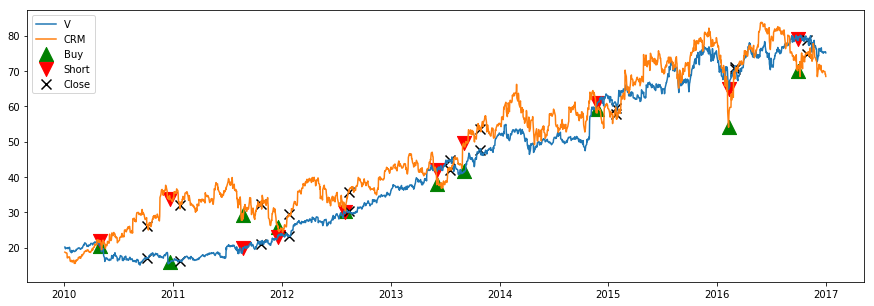

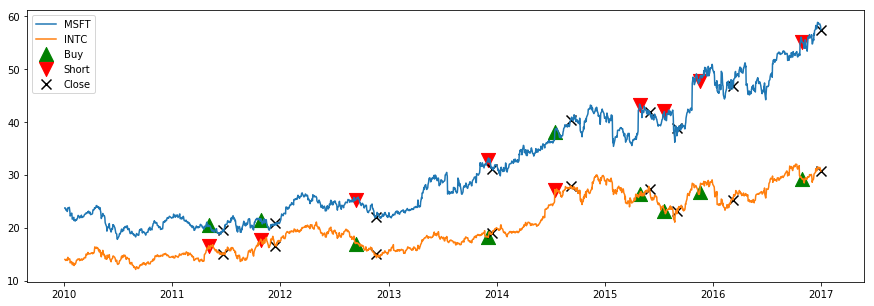

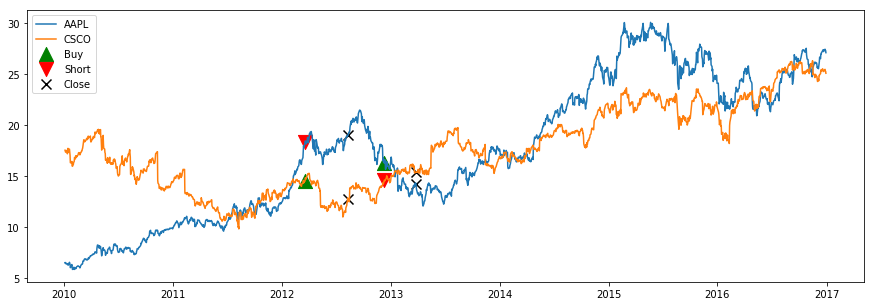


Strategy Performance
Strategy Returns: -6.53%
Strategy Annual Gross Returns: -0.96%
Strategy Standard Deviation: 7.9
Alpha: -0.96
Beta: 0.0
Sharpe Ratio: -0.12

Market Performance
Market Returns: 124.17%
Market Annual Gross Returns: 12.24%
Market Standard Deviation: 23.46


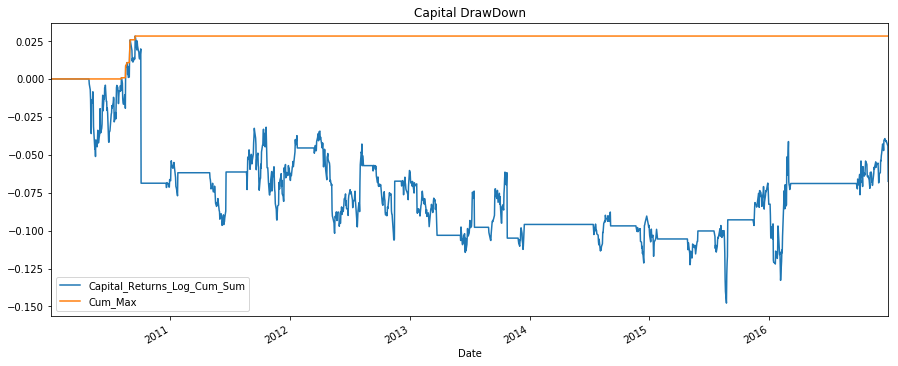

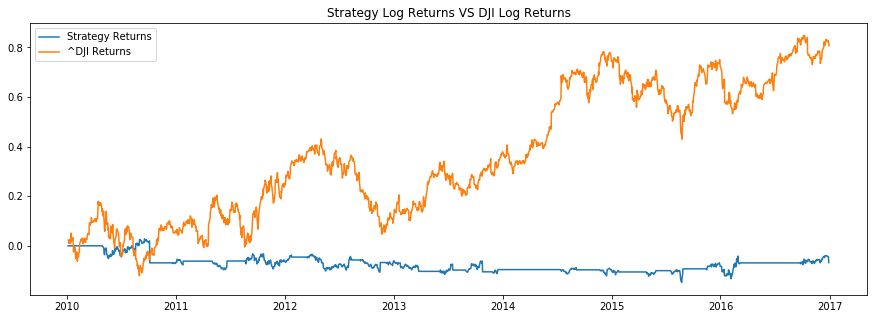

Resetting BackTester

Strategy Iteration: ATR_RATIO



911720.3313251494
Open Trade V | 2010-01-22 | Sell
Open Price: $18.9
Quantity: 4364
Transaction Cost: $824.95
Total Price: $83319.8

Closing Trade V | 2010-06-03 | Buy
Close Price: $16.69
Quantity: 4364 
Transaction Cost: $728.5
Total Transaction Cost: $1553.45
Total Price: $73578.84
Log Returns: 0.12
Raw Profits: $8091.07
Open Trade V | 2010-08-20 | Buy
Open Price: $16.09
Quantity: 5624
Transaction Cost: $905.03
Total Price: $91407.83

Closing Trade V | 2012-02-22 | Sell
Close Price: $27.03
Quantity: 5624 
Transaction Cost: $1520.17
Total Transaction Cost: $2425.19
Total Price: $153536.67
Log Returns: 0.52
Raw Profits: $59088.52
Open Trade V | 2013-05-02 | Sell
Open Price: $41.07
Quantity: 3627
Transaction Cost: $1489.69
Total Price: $150459.15

Closing Trade V | 2013-05-29 | Buy
Close Price: $41.79
Quantity: 3627 
Transaction Cost: $1515.74
Total Transaction Cost: $3005.43
Total Price: $153089.72
Log Returns: -0.02
Raw Profits: $-5609.96
Open Trade V | 2013-07-31 | Sell
Open Price: 

Transaction Cost: $1472.06
Total Price: $148678.54

Closing Trade CRM | 2016-12-30 | Sell
Close Price: $68.46
Quantity: 2008 
Transaction Cost: $1374.68
Total Transaction Cost: $2846.74
Total Price: $138842.35
Log Returns: -0.07
Raw Profits: $-12585.54
Open Trade AAPL | 2010-01-22 | Buy
Open Price: $6.02
Quantity: 13705
Transaction Cost: $825.07
Total Price: $83331.95

Closing Trade AAPL | 2012-08-17 | Sell
Close Price: $19.82
Quantity: 13705 
Transaction Cost: $2715.71
Total Transaction Cost: $3540.78
Total Price: $274286.49
Log Returns: 1.19
Raw Profits: $185523.12
Open Trade AAPL | 2012-09-24 | Sell
Open Price: $21.12
Quantity: 12603
Transaction Cost: $2661.8
Total Price: $268841.64

Closing Trade AAPL | 2013-02-28 | Buy
Close Price: $13.64
Quantity: 12603 
Transaction Cost: $1718.56
Total Transaction Cost: $4380.36
Total Price: $173574.37
Log Returns: 0.44
Raw Profits: $89943.67
Open Trade AAPL | 2014-09-09 | Sell
Open Price: $21.96
Quantity: 16179
Transaction Cost: $3552.27
Total 

Quantity: 4165 
Transaction Cost: $1009.88
Total Transaction Cost: $2088.95
Total Price: $101998.21
Log Returns: 0.07
Raw Profits: $4829.26
Open Trade INTC | 2015-08-06 | Buy
Open Price: $23.61
Quantity: 4772
Transaction Cost: $1126.67
Total Price: $113793.82

Closing Trade INTC | 2015-09-30 | Sell
Close Price: $24.53
Quantity: 4772 
Transaction Cost: $1170.56
Total Transaction Cost: $2297.23
Total Price: $118226.34
Log Returns: 0.04
Raw Profits: $2091.4
Open Trade INTC | 2015-10-26 | Buy
Open Price: $28.15
Quantity: 4075
Transaction Cost: $1147.17
Total Price: $115864.04

Closing Trade INTC | 2016-09-16 | Sell
Close Price: $31.65
Quantity: 4075 
Transaction Cost: $1289.86
Total Transaction Cost: $2437.03
Total Price: $130275.53
Log Returns: 0.12
Raw Profits: $11831.78
Open Trade INTC | 2016-11-14 | Buy
Open Price: $29.19
Quantity: 4331
Transaction Cost: $1264.3
Total Price: $127694.12

Closing Trade INTC | 2016-12-30 | Sell
Close Price: $30.71
Quantity: 4331 
Transaction Cost: $1329.9

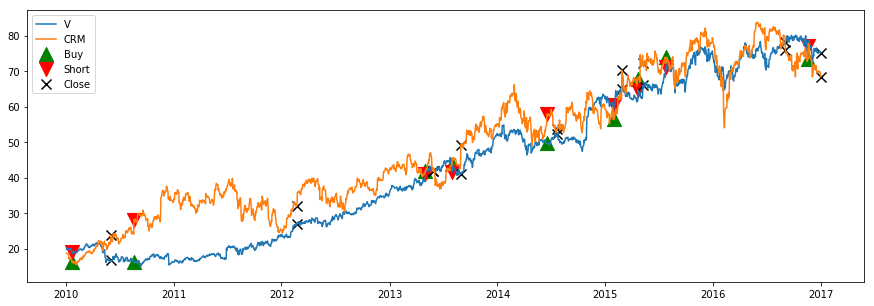

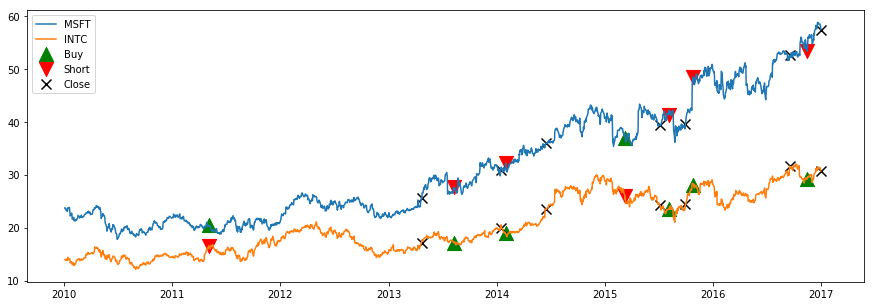

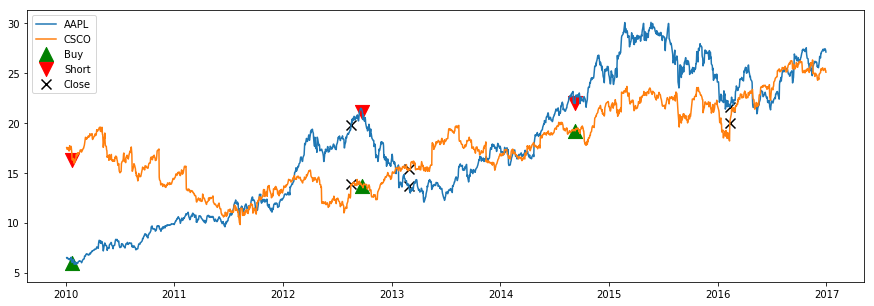


Strategy Performance
Strategy Returns: 82.34%
Strategy Annual Gross Returns: 8.98%
Strategy Standard Deviation: 18.34
Alpha: 8.74
Beta: 0.02
Sharpe Ratio: 0.49

Market Performance
Market Returns: 124.17%
Market Annual Gross Returns: 12.24%
Market Standard Deviation: 23.46


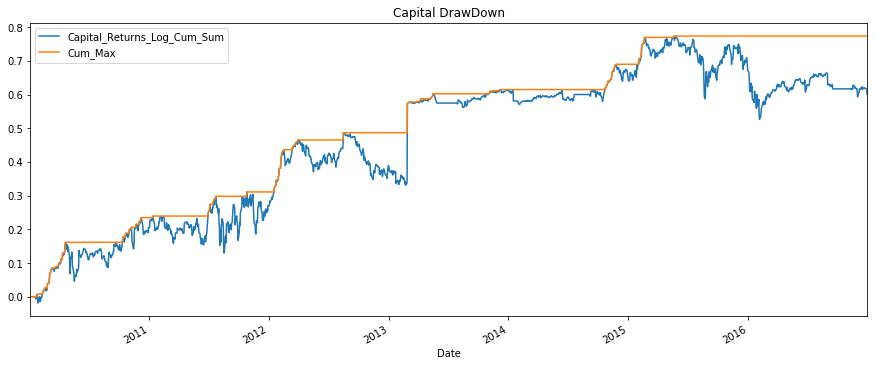

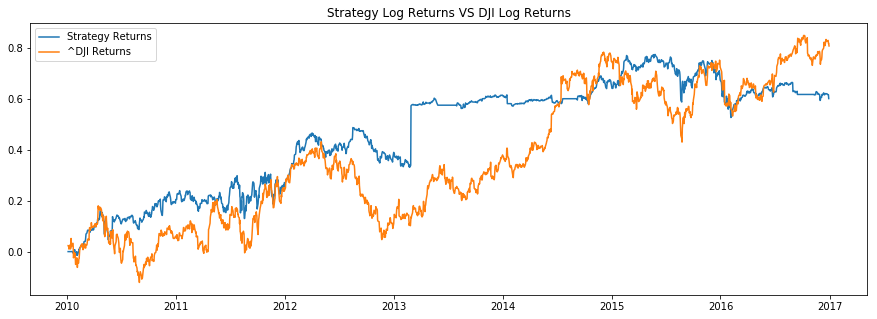

Resetting BackTester



In [24]:
A = Pair_Strategy(stocks, "2010-01-01", "2016-12-31","1d", 500000, 0.01, "^DJI" ,verbose=True, number_pairs=3, types=strategy_types)
A.run_strategy()

C:\Users\Weilin\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in double_scalars



Strategy Performance
Strategy Returns: 0.0%
Strategy Annual Gross Returns: 0.0%
Strategy Standard Deviation: 0.0
Alpha: 0.0
Beta: 0.0
Sharpe Ratio: nan

Market Performance
Market Returns: 124.17%
Market Annual Gross Returns: 12.24%
Market Standard Deviation: 23.46


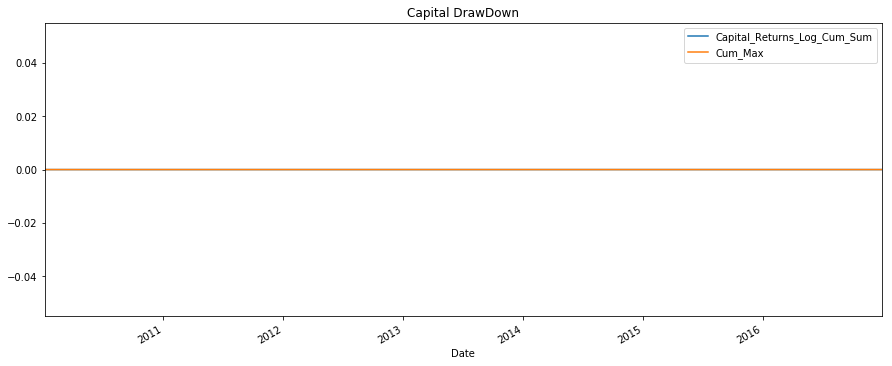

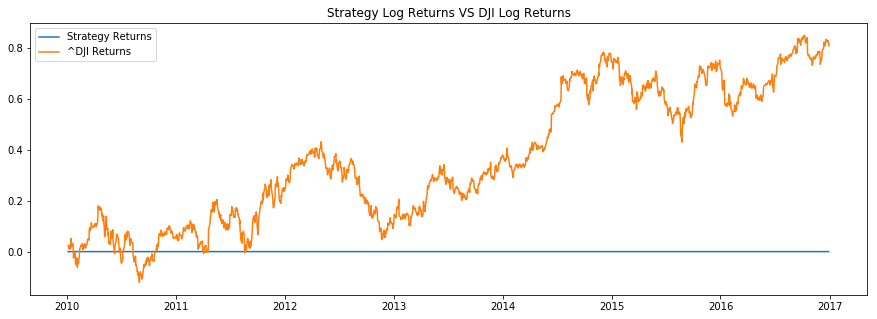

ZeroDivisionError: float division by zero